In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import the csv dataset from googledrive location
zomato = pd.read_csv('/content/drive/MyDrive/CS267_Project_Dataset/zomato2.csv')
zomato.head(1)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari


In [ ]:
# Take required features
zomato_e1 = zomato[(['name','rate', 'approx_cost(for two people)', 'online_order','votes','rest_type','cuisines','listed_in(type)','listed_in(city)'])]
# replace the positive and negative infinite valyes with nan
zomato_e1.replace([np.inf, -np.inf], np.nan, inplace=True)
# drop all the entries containing na
zomato_e1=zomato_e1.dropna()
zomato_e1

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [ ]:
# Only select values which are not null
zomato_e1 = zomato_e1[zomato_e1.cuisines.notnull()]
# Remove all entries containing cusine as Heatlthy food
zomato_e1 = zomato_e1[zomato_e1.cuisines.str.contains('Healthy Food')==False]
# Remove all entries containing cusine as Raw Meats
zomato_e1 = zomato_e1[zomato_e1.cuisines.str.contains('Raw Meats')==False]
# Reduce the number of unique cuisines by creating a superset. Multiple cusine values will come under  'Multi Cuisne' class 
zomato_e1.loc[zomato_e1["cuisines"].str.contains(',|World Cuisine|International|Cuisine Varies')==True, "cuisines"] = 'Multi Cuisine'
zomato_e1.loc[zomato_e1["cuisines"].str.contains('Japanese|Sushi')==True, "cuisines"] = 'Japanese'
zomato_e1.loc[zomato_e1["cuisines"].str.contains('Korean')==True, "cuisines"] = 'Korean'
zomato_e1.loc[zomato_e1["cuisines"].str.contains('Chinese')==True, "cuisines"] = 'Chinese'
zomato_e1.loc[zomato_e1["cuisines"].str.contains('Mithai|Desserts|Ice Cream|Chinese')==True, "cuisines"] = 'Desserts'
zomato_e1.loc[zomato_e1["cuisines"].str.contains('Modern Australian|Australian')==True, "cuisines"] = 'Australian'
zomato_e1.loc[zomato_e1["cuisines"].str.contains('Cafe|Breakfast|Sandwich|Bakery|Beverages|Street Food|cafe|Fast Food|Juices|Tea')==True, "cuisines"] = 'cafe'
zomato_e1.loc[zomato_e1["cuisines"].str.contains('Brazilian|Steak')==True, "cuisines"] = 'Brazilian'
zomato_e1.loc[zomato_e1["cuisines"].str.contains('Italian|Pizza')==True, "cuisines"] = 'Italian'
zomato_e1.loc[zomato_e1["cuisines"].str.contains('Kebab')==True, "cuisines"] = 'Mediterranean'
zomato_e1.loc[zomato_e1["cuisines"].str.contains('Continental')==True, "cuisines"] = 'European'
zomato_e1.loc[zomato_e1["cuisines"].str.contains('American|BBQ|Burger')==True, "cuisines"] = 'American'
zomato_e1.loc[zomato_e1["cuisines"].str.contains('Mexican')==True, "cuisines"] = 'Mexican'
zomato_e1.loc[zomato_e1["cuisines"].str.contains('Bar Food|Drinks Only|Finger Food|Pub Food')==True, "cuisines"] = 'Bar'
zomato_e1.cuisines.unique()

array(['Multi Cuisine', 'North Indian', 'cafe', 'Italian', 'Biryani',
       'South Indian', 'Desserts', 'Arabian', 'Vietnamese', 'Andhra',
       'Rolls', 'Bar', 'European', 'Mediterranean', 'Maharashtrian',
       'Bohri', 'Bengali', 'American', 'Rajasthani', 'Mangalorean',
       'Seafood', 'Kerala', 'Gujarati', 'Mughlai', 'Turkish',
       'Modern Indian', 'Bihari', 'Lebanese', 'Thai', 'Burmese',
       'North Eastern', 'Chettinad', 'Asian', 'Mexican', 'Japanese',
       'Spanish', 'Oriya', 'Tibetan', 'Kashmiri', 'Korean', 'Assamese',
       'Hyderabadi'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
#Take the Ordinal encoder 
ord_enc = OrdinalEncoder()
# Encode all the String values to floats
zomato_e1["online_order"] = ord_enc.fit_transform(zomato_e1[["online_order"]])
zomato_e1["rest_type"] = ord_enc.fit_transform(zomato_e1[["rest_type"]])
zomato_e1["cuisines"] = ord_enc.fit_transform(zomato_e1[["cuisines"]])
zomato_e1["listed_in(type)"] = ord_enc.fit_transform(zomato_e1[["listed_in(type)"]])
# only take the normal rate i.e from 4.5/5 rating format keep 4.5
zomato_e1["rate"] = zomato_e1["rate"].str[:3]
zomato_e1["rate"]=zomato_e1["rate"].dropna()
zomato_e1["listed_in(city)"] = ord_enc.fit_transform(zomato_e1[["listed_in(city)"]])
zomato_e1["approx_cost(for two people)"]=zomato_e1["approx_cost(for two people)"].dropna()
# Remove - and NEW strings from the table
zomato_e1=zomato_e1[zomato_e1.rate.str.contains('NEW')==False]
zomato_e1=zomato_e1[zomato_e1.rate.str.contains('-')==False]
# convert votes from string to float
zomato_e1["rate"] = zomato_e1["rate"].astype(float)
# conversion of cost to float
zomato_e1["approx_cost(for two people)"]=zomato_e1["approx_cost(for two people)"].str.replace(',','')
zomato_e1["approx_cost(for two people)"] = zomato_e1["approx_cost(for two people)"].astype(float)
# convert votes from string to float
zomato_e1["votes"] = zomato_e1["votes"].astype(float)
# the below values were tested with a decesion tree classifier instead of using a regressor ( For better understanding of the  difference and trying our hands on different things for experementation)
zomato_e1.loc[zomato_e1["rate"] <= 2, "review"] = 'bad'
zomato_e1.loc[(zomato_e1["rate"] > 2) & (zomato_e1["rate"] < 3), "review"] = 'ok'
zomato_e1.loc[(zomato_e1["rate"] >= 3) & (zomato_e1["rate"] < 4), "review"] = 'good'
zomato_e1.loc[(zomato_e1["rate"] >= 4) & (zomato_e1["rate"] < 5), "review"] = 'great'
zomato_e1.loc[zomato_e1["rate"] == 5, "review"] = 'excellent'
# select the input and output as X and Y respectively
X = zomato_e1[['approx_cost(for two people)', 'online_order','votes','rest_type','cuisines','listed_in(type)','listed_in(city)']]
zomato_e1 = zomato_e1.reset_index()

In [ ]:
from sklearn.tree import DecisionTreeRegressor
Yl_1 = zomato_e1['rate']
# split the data into test and train 
xdt_train,xdt_test,ydt_train,ydt_test=train_test_split(X,Yl_1,test_size=.3,random_state=105)
# decision tree model initializer
DTree=DecisionTreeRegressor(min_samples_leaf=1)
#train the model
DTree.fit(xdt_train,ydt_train)
#predict on the test data
ydt_predict=DTree.predict(xdt_test)
from sklearn.metrics import r2_score
r2_score(ydt_test,ydt_predict)

0.6905569030216083

In [ ]:
# take the input from sentiment analysis
sentiment_score = pd.read_csv('/content/drive/MyDrive/CS267_Project_Dataset/sentimentscore.csv')

In [ ]:
#merge the old features with the newly calculated features and perform removal of infinite values
zomato_with_sc = pd.merge(zomato_e1, sentiment_score,how='right', on='name')
zomato_with_reult = zomato_with_sc.drop_duplicates()
zomato_with_reult.replace([np.inf, -np.inf], np.nan, inplace=True)
zomato_with_reult=zomato_with_reult.dropna()
zomato_with_reult

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,index,name,rate_x,approx_cost(for two people),online_order,votes,rest_type,cuisines,listed_in(type),listed_in(city),review,rate_y,roberta_pos,roberta_neu,roberta_neg
0,0.0,Jalsa,4.1,800.0,1.0,775.0,24.0,28.0,0.0,1.0,great,4.1,0.981752,0.016056,0.002192
1,456.0,Jalsa,4.1,800.0,1.0,775.0,24.0,28.0,2.0,1.0,great,4.1,0.981752,0.016056,0.002192
2,559.0,Jalsa,4.1,800.0,1.0,775.0,24.0,28.0,4.0,1.0,great,4.1,0.981752,0.016056,0.002192
3,2488.0,Jalsa,4.1,800.0,1.0,775.0,24.0,28.0,0.0,3.0,great,4.1,0.981752,0.016056,0.002192
4,2966.0,Jalsa,4.1,800.0,1.0,775.0,24.0,28.0,2.0,3.0,great,4.1,0.981752,0.016056,0.002192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261792,25108.0,Leung Fast Food,3.5,400.0,0.0,12.0,73.0,28.0,4.0,14.0,good,3.5,0.991622,0.005282,0.003095
261793,26400.0,Leung Fast Food,3.5,400.0,0.0,13.0,73.0,28.0,4.0,15.0,good,3.5,0.991622,0.005282,0.003095
261806,25112.0,New Udupi Park Deluxe,3.6,400.0,0.0,77.0,73.0,28.0,4.0,14.0,good,3.6,0.903113,0.090785,0.006102
261807,26455.0,New Udupi Park Deluxe,3.6,400.0,0.0,77.0,73.0,28.0,4.0,15.0,good,3.6,0.903113,0.090785,0.006102


In [ ]:
# input and output for the post sentiment analysis
X_s = zomato_with_reult[['approx_cost(for two people)', 'online_order','votes','rest_type','cuisines','listed_in(type)','roberta_pos','roberta_neu','roberta_neg','listed_in(city)']]
Y_s = zomato_with_reult['rate_x']
zomato_e1s = zomato_with_reult.reset_index()

In [ ]:
# split training and testing data
xdts_train,xdts_test,ydts_train,ydts_test=train_test_split(X_s,Y_s,test_size=.3,random_state=105)
#initialize the model
DTrees=DecisionTreeRegressor(min_samples_leaf=1)
#Train the model
DTrees.fit(xdts_train,ydts_train)
# test with the test dataset
ydts_predict=DTrees.predict(xdts_test)
r2_score(ydts_test,ydts_predict)

0.8951574851860034

In [ ]:
from sklearn import metrics
# root mean square error calculation for pre sentiment analysis
np.sqrt(metrics.mean_squared_error(ydt_test, ydt_predict))

0.24702242303728927

In [ ]:
# root mean square error calculation for pre sentiment analysis
np.sqrt(metrics.mean_squared_error(ydts_test, ydts_predict))

0.14671707621768434

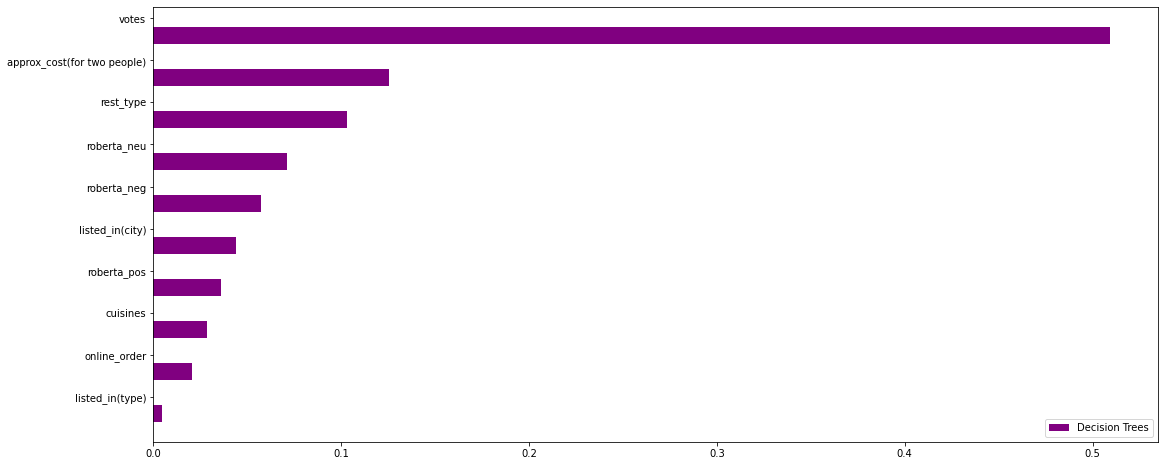

In [ ]:
# extract graph for feature extraction importance
feature_importance=pd.DataFrame({
    'rfc':DTrees.feature_importances_
},index=zomato_with_sc.drop(columns=['name','index','rate_y','rate_x','review']).columns)
feature_importance.sort_values(by='rfc',ascending=True,inplace=True)

index = np.arange(len(feature_importance))
fig, ax = plt.subplots(figsize=(18,8))
rfc_feature=ax.barh(index,feature_importance['rfc'],0.4,color='purple',label='Decision Trees')
ax.set(yticks=index+0.4,yticklabels=feature_importance.index)

ax.legend()
plt.show()